# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [4]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64
                                                    , shuffle=True, num_workers=2)
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1
                                                     , shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 1/938 [00:00<03:33,  4.39it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super(SimpleMLP,self).__init__()
        self.input_size = in_size
        self.hidden_size = hid_size
        self.output_size = out_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
    def forward(self,x):
        # code here
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = x.to(device)
        return output

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [8]:
# code here
class Optimisers():
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
    
    def SGD(self):
        return optim.SGD(self.model.parameters(), lr=self.lr)

    def SGD_mom(self, momentum):
        return optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum)

    def SGD_L2(self, wd):
        return optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=wd)
    
    def RMSprop(self, alpha,eps):
        return optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=alpha, eps=eps)

    def Adam(self, b1, b2, eps):
        return optim.Adam(self.model.parameters(), lr=self.lr, betas=(b1, b2), eps=eps)

### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [9]:
# hyperparameters
input_size = 28*28
hidden_size = 64
output_size = 10
num_epochs = 5
learning_rate = 1e-3
momentum = 0.9
weight_decay = 1e-4
alpha = 0.99
eps = 1e-08
beta_1 = 0.9
beta_2 = 0.999

In [ ]:
class TrainModel():
    def __init__(self):
        pass

    def make_optim_choice(self, choice):
        if choice == 1:
            return self.optimisers.SGD()
        elif choice == 2:
            return self.optimisers.SGD_mom(momentum=momentum)
        elif choice == 3:
            return self.optimisers.SGD_L2(wd=weight_decay)
        elif choice == 4:
            return self.optimisers.RMSprop(alpha=alpha, eps=eps)
        elif choice == 5:
            return self.optimisers.Adam(b1=beta_1, b2=beta_2, eps=eps)

    def train_model(self):
        self.train_loss, self.test_loss = list(), list()
        self.model.train()
        pbar = tqdm(total=len(trainloader_minibatch))
        for epoch in range(num_epochs):
            tr_loss = 0
            for batch_idx, (data, target) in enumerate(trainloader_minibatch):
                data = data.view(-1, input_size)
                data = data.to(device)
                target = target.to(device)
                self.optimiser.zero_grad()
                out = self.model(data)
                loss = self.criterion(out, target)
                tr_loss += loss.item()

                loss.backward()
                self.optimiser.step()
                pbar.update(1)
            x_l = tr_loss/len(trainloader_minibatch)
            self.train_loss.append(x_l)

            self.model.eval()
            with torch.no_grad():
                te_loss = 0
                for batch_idx, (data, target) in enumerate(testloader):
                    data = data.view(-1, input_size)
                    data = data.to(device)
                    target = target.to(device)
                    out = self.model(data)
                    loss = self.criterion(out, target)
                    te_loss += loss.item()
                x_l = te_loss/len(testloader)
                self.test_loss.append(x_l)
            pbar.set_description(f"Epoch: {epoch}, Train Loss: {self.train_loss[-1]}, Test Loss: {self.test_loss[-1]}")
        pbar.close()

    def save_model(self, choice):
        path_model = '/content/drive/MyDrive/MLP_model_' + str(choice) + '.pth'
        path_loss1 = '/content/drive/MyDrive/train_loss_model_' + str(choice) + '.npy'
        path_loss2 = '/content/drive/MyDrive/test_loss_model_' + str(choice) + '.npy'

        # save the model
        torch.save(self.model.state_dict(), path_model)
        # save the losses
        np.save(path_loss1, np.array(self.train_loss))
        np.save(path_loss2, np.array(self.test_loss))


    def main(self):
        for i in range(1, 6):
            self.model = SimpleMLP(input_size, hidden_size, output_size).to(device)
            self.optimisers = Optimisers(self.model, lr=learning_rate)
            self.criterion = nn.CrossEntropyLoss()
            self.optimiser = self.make_optim_choice(i)
            print(f"Training model {i}")
            self.train_model()
            print(f"Saving model {i}")
            self.save_model(i)

In [ ]:
tm = TrainModel()
tm.main()

Training model 1




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:58,  7.92it/s]

  1%|          | 8/938 [00:00<00:23, 40.13it/s]

  2%|▏         | 16/938 [00:00<00:17, 53.48it/s]

  2%|▏         | 22/938 [00:00<00:16, 55.71it/s]

  3%|▎         | 28/938 [00:00<00:16, 54.70it/s]

  4%|▍         | 36/938 [00:00<00:14, 61.92it/s]

  5%|▍         | 43/938 [00:00<00:14, 60.79it/s]

  5%|▌         | 51/938 [00:00<00:13, 65.47it/s]

  6%|▋         | 59/938 [00:01<00:12, 67.70it/s]

  7%|▋         | 67/938 [00:01<00:12, 68.34it/s]

  8%|▊         | 76/938 [00:01<00:11, 71.89it/s]

  9%|▉         | 84/938 [00:01<00:12, 68.85it/s]

 10%|▉         | 93/938 [00:01<00:11, 71.04it/s]

 11%|█         | 101/938 [00:01<00:11, 71.84it/s]

 12%|█▏        | 109/938 [00:01<00:11, 72.11it/s]

 12%|█▏        | 117/938 [00:01<00:11, 73.80it/s]

 13%|█▎        | 125/938 [00:01<00:11, 71.53it/s]

 14%|█▍        | 135/938 [00:02<00:10, 79.12it/s]

 16%|█▌        | 147/938 [00:02<00:09, 87.84it/s]

 17

Saving model 1
Training model 2




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:28,  6.31it/s]

  1%|          | 7/938 [00:00<00:29, 31.56it/s]

  1%|▏         | 14/938 [00:00<00:20, 44.98it/s]

  2%|▏         | 22/938 [00:00<00:17, 52.85it/s]

  3%|▎         | 30/938 [00:00<00:15, 60.30it/s]

  4%|▍         | 37/938 [00:00<00:15, 57.60it/s]

  5%|▍         | 43/938 [00:00<00:15, 58.15it/s]

  5%|▌         | 50/938 [00:00<00:15, 58.27it/s]

  6%|▌         | 56/938 [00:01<00:16, 54.40it/s]

  7%|▋         | 62/938 [00:01<00:18, 46.38it/s]

  7%|▋         | 68/938 [00:01<00:19, 43.93it/s]

  8%|▊         | 73/938 [00:01<00:19, 44.91it/s]

  8%|▊         | 78/938 [00:01<00:22, 39.01it/s]

  9%|▉         | 83/938 [00:01<00:20, 41.36it/s]

  9%|▉         | 89/938 [00:01<00:18, 45.91it/s]

 10%|█         | 96/938 [00:02<00:17, 49.24it/s]

 11%|█         | 102/938 [00:02<00:16, 50.43it/s]

 12%|█▏        | 108/938 [00:02<00:16, 51.84it/s]

 12%|█▏        | 117/938 [00:02<00:13, 58.72it/s]

 13%|█

Saving model 2
Training model 3




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:14,  6.99it/s]

  1%|          | 7/938 [00:00<00:28, 32.78it/s]

  1%|▏         | 13/938 [00:00<00:21, 43.34it/s]

  2%|▏         | 23/938 [00:00<00:15, 60.73it/s]

  4%|▎         | 34/938 [00:00<00:12, 74.81it/s]

  5%|▍         | 44/938 [00:00<00:10, 82.30it/s]

  6%|▌         | 54/938 [00:00<00:10, 87.22it/s]

  7%|▋         | 65/938 [00:00<00:09, 92.64it/s]

  8%|▊         | 76/938 [00:00<00:08, 96.21it/s]

  9%|▉         | 86/938 [00:01<00:08, 96.85it/s]

 10%|█         | 96/938 [00:01<00:08, 96.66it/s]

 11%|█▏        | 106/938 [00:01<00:08, 97.21it/s]

 12%|█▏        | 117/938 [00:01<00:08, 100.84it/s]

 14%|█▎        | 128/938 [00:01<00:07, 101.64it/s]

 15%|█▍        | 139/938 [00:01<00:07, 103.06it/s]

 16%|█▌        | 150/938 [00:01<00:07, 100.73it/s]

 17%|█▋        | 162/938 [00:01<00:07, 102.67it/s]

 18%|█▊        | 173/938 [00:01<00:07, 104.74it/s]

 20%|█▉        | 184/938 [00:02<00:07, 104.54i

Saving model 3
Training model 4




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:39,  9.40it/s]

  1%|▏         | 12/938 [00:00<00:15, 61.34it/s]

  2%|▏         | 23/938 [00:00<00:11, 81.05it/s]

  4%|▎         | 33/938 [00:00<00:10, 86.49it/s]

  5%|▍         | 43/938 [00:00<00:10, 87.22it/s]

  6%|▌         | 53/938 [00:00<00:09, 90.73it/s]

  7%|▋         | 64/938 [00:00<00:09, 96.28it/s]

  8%|▊         | 75/938 [00:00<00:08, 98.00it/s]

  9%|▉         | 85/938 [00:00<00:08, 98.03it/s]

 10%|█         | 95/938 [00:01<00:08, 97.14it/s]

 11%|█         | 105/938 [00:01<00:08, 96.19it/s]

 12%|█▏        | 115/938 [00:01<00:08, 96.05it/s]

 13%|█▎        | 125/938 [00:01<00:08, 95.85it/s]

 14%|█▍        | 135/938 [00:01<00:08, 94.39it/s]

 15%|█▌        | 145/938 [00:01<00:08, 92.00it/s]

 17%|█▋        | 155/938 [00:01<00:08, 93.89it/s]

 18%|█▊        | 165/938 [00:01<00:08, 95.58it/s]

 19%|█▊        | 175/938 [00:01<00:08, 94.03it/s]

 20%|█▉        | 185/938 [00:02<00:08, 88.96it/s]


Saving model 4
Training model 5




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:20,  6.66it/s]

  1%|          | 7/938 [00:00<00:31, 29.58it/s]

  2%|▏         | 15/938 [00:00<00:19, 47.82it/s]

  2%|▏         | 21/938 [00:00<00:17, 51.72it/s]

  3%|▎         | 27/938 [00:00<00:17, 52.54it/s]

  4%|▎         | 34/938 [00:00<00:16, 54.84it/s]

  4%|▍         | 42/938 [00:00<00:15, 59.10it/s]

  5%|▌         | 49/938 [00:00<00:14, 61.98it/s]

  6%|▌         | 56/938 [00:01<00:13, 63.40it/s]

  7%|▋         | 63/938 [00:01<00:14, 58.81it/s]

  8%|▊         | 73/938 [00:01<00:12, 66.98it/s]

  9%|▉         | 83/938 [00:01<00:11, 73.81it/s]

 10%|▉         | 92/938 [00:01<00:11, 74.30it/s]

 11%|█         | 101/938 [00:01<00:10, 77.12it/s]

 12%|█▏        | 110/938 [00:01<00:10, 80.54it/s]

 13%|█▎        | 119/938 [00:01<00:09, 82.24it/s]

 14%|█▎        | 128/938 [00:01<00:09, 82.03it/s]

 15%|█▍        | 138/938 [00:02<00:09, 84.64it/s]

 16%|█▌        | 148/938 [00:02<00:09, 86.99it/s]

 17

Saving model 5


#### Plotting losses

In [ ]:
def plot_losses():
    for i in range(1, 6):
        path_loss1 = '/content/drive/MyDrive/train_loss_model_' + str(i) + '.npy'
        path_loss2 = '/content/drive/MyDrive/test_loss_model_' + str(i) + '.npy'

        train_loss = np.load(path_loss1)
        test_loss = np.load(path_loss2)
        plt.plot(train_loss, label='train')
        plt.plot(test_loss, label='test')
        plt.legend()
        titles = ['SGD', 'SGD with momentum', 'SGD with L2 regularisation', 'RMSprop', 'Adam']
        t = titles[i-1]
        plt.title(t)
        plt.show()

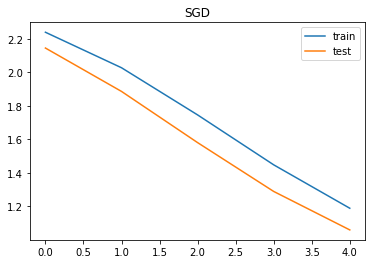

Epoch: 3, Train Loss: 0.11570467866127139, Test Loss: 0.018202602286075453: : 3797it [09:14,  6.84it/s]


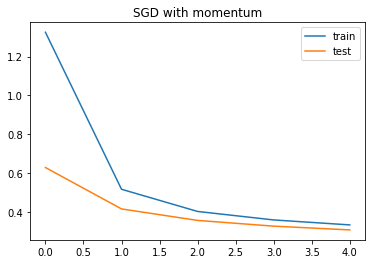

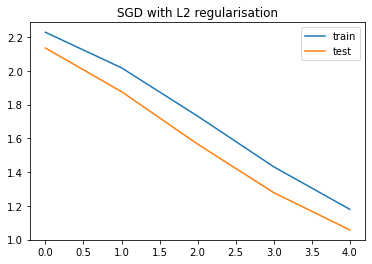

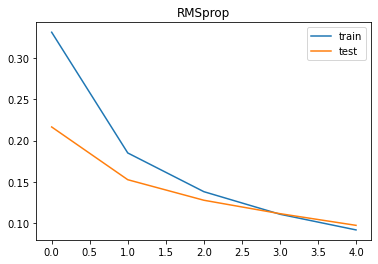

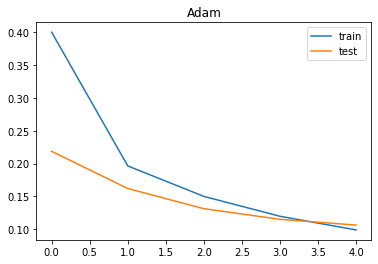

In [ ]:
plot_losses()

#### Finding scores

In [ ]:
def find_scores():
    for i in range(1, 6):
        titles = ['SGD', 'SGD with momentum', 'SGD with L2 regularisation', 'RMSprop', 'Adam']
        t = titles[i-1]
        print(t)
        path_model = '/content/drive/MyDrive/MLP_model_' + str(i) + '.pth'
        model = SimpleMLP(input_size, hidden_size, output_size)
        model.load_state_dict(torch.load(path_model))
        model.to(device)
        train_pred, train_label = list(), list()
        for batch_idx, (data, target) in enumerate(trainloader_minibatch):
            data = data.view(-1, input_size)
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            pred = torch.argmax(out, dim = 1)
            train_pred.append(pred)
            train_label.append(target)
        train_pred = torch.cat(train_pred, dim=0).cpu()
        train_label = torch.cat(train_label, dim=0).cpu()

        train_acc = accuracy_score(train_label, train_pred)
        train_prec = precision_score(train_label, train_pred, average='macro')
        train_recall = recall_score(train_label, train_pred, average='macro')
        train_f1 = f1_score(train_label, train_pred, average='macro')

        test_pred, test_label = list(), list()
        for batch_idx, (data, target) in enumerate(testloader):
            data = data.view(-1, input_size)
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            pred = torch.argmax(out, dim = 1)
            test_pred.append(pred)
            test_label.append(target)
        test_pred = torch.cat(test_pred, dim=0).cpu()
        test_label = torch.cat(test_label, dim=0).cpu()

        test_acc = accuracy_score(test_label, test_pred)
        test_prec = precision_score(test_label, test_pred, average='macro')
        test_recall = recall_score(test_label, test_pred, average='macro')
        test_f1 = f1_score(test_label, test_pred, average='macro')

        df = pd.DataFrame({'Train': [train_acc, train_prec, train_recall, train_f1], 'Test': [test_acc, test_prec, test_recall, test_f1]}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
        print(df)
        print()


In [ ]:
find_scores()

SGD
              Train      Test
Accuracy   0.801833  0.804500
Precision  0.811100  0.812903
Recall     0.796489  0.799362
F1 Score   0.794724  0.797007

SGD with momentum
              Train      Test
Accuracy   0.907983  0.913400
Precision  0.907077  0.912446
Recall     0.906537  0.911978
F1 Score   0.906623  0.911957

SGD with L2 regularisation
              Train      Test
Accuracy   0.806450  0.817100
Precision  0.813399  0.823094
Recall     0.801047  0.812283
F1 Score   0.798688  0.809795

RMSprop
              Train      Test
Accuracy   0.978783  0.971200
Precision  0.978662  0.971021
Recall     0.978659  0.970985
F1 Score   0.978652  0.970973

Adam
              Train      Test
Accuracy   0.975833  0.968400
Precision  0.975801  0.968402
Recall     0.975593  0.968044
F1 Score   0.975645  0.968144



### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

In [ ]:
# code and analysis here
def using_schedulers(model, optimiser, criterion, choice):
    milestones = [2,4,6,8]
    if i == 0:
        scheduler = optim.lr_scheduler.MultiStepLR(optimiser, milestones=milestones, gamma=0.1)
    elif i == 1:
        scheduler = optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.1)
    train_loss, test_loss = list(), list()
    model.train()
    pbar = tqdm(total=len(trainloader_minibatch))
    for epoch in range(num_epochs):
        tr_loss = 0
        for batch_idx, (data, target) in enumerate(trainloader_minibatch):
            data = data.view(-1, input_size)
            data = data.to(device)
            target = target.to(device)
            optimiser.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            tr_loss += loss.item()

            loss.backward()
            optimiser.step()
            pbar.update(1)
        x_l = tr_loss/len(trainloader_minibatch)
        train_loss.append(x_l)

        model.eval()
        with torch.no_grad():
            te_loss = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.view(-1, input_size)
                data = data.to(device)
                target = target.to(device)
                out = model(data)
                loss = criterion(out, target)
                te_loss += loss.item()
            x_l = te_loss/len(testloader)
            test_loss.append(x_l)
        pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")
        scheduler.step()
    pbar.close()

    print(f'saving model {choice}')
    model_path = '/content/drive/MyDrive/model_adam_scheduler_' + str(choice) + '.pth'
    path_loss1 = '/content/drive/MyDrive/train_loss_scheduler_' + str(choice) + '.npy'
    path_loss2 = '/content/drive/MyDrive/test_loss_scheduler_' + str(choice) + '.npy'

    torch.save(model.state_dict(), model_path)
    np.save(path_loss1, np.array(train_loss))
    np.save(path_loss2, np.array(test_loss))

In [ ]:
for i in range(2):
    model = SimpleMLP(input_size, hidden_size, output_size).to(device)
    optimiser = Optimisers(model, lr=learning_rate).Adam(b1=beta_1, b2=beta_2, eps=eps)
    criterion = nn.CrossEntropyLoss()
    using_schedulers(model, optimiser, criterion, i)


 99%|█████████▉| 932/938 [00:11<00:00, 92.33it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: 100%|██████████| 938/938 [00:13<00:00, 92.33it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 942it [00:13, 17.08it/s]                       
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 952it [00:13, 22.67it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 962it [00:13, 29.36it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 971it [00:13, 36.10it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 981it [00:13, 44.78it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 991it [00:13, 53.11it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 1002it [00:14, 61.83it/s]
Epoch: 0, Train Loss: 0.39195265741284085, Test Loss: 0.21262975970793302: : 1013it [0

saving model 0



100%|█████████▉| 935/938 [00:10<00:00, 58.45it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: 100%|██████████| 938/938 [00:12<00:00, 58.45it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 941it [00:12,  9.57it/s]                       
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 952it [00:13, 15.32it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 961it [00:13, 20.95it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 971it [00:13, 28.44it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 981it [00:13, 36.61it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 992it [00:13, 46.51it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 1003it [00:13, 56.27it/s]
Epoch: 0, Train Loss: 0.3968377489207396, Test Loss: 0.23196787342049513: : 1013it [00:13, 63.

saving model 1


#### Plotting losses

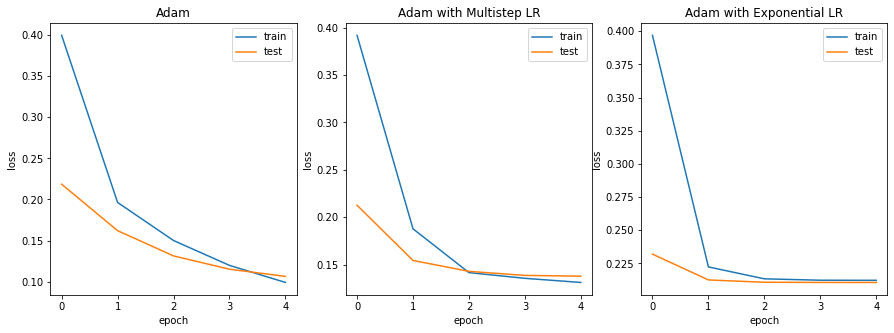

In [ ]:
def get_adam_arr(choice):
    train_path, test_path = str(), str()
    if choice == 1:
        train_path = '/content/drive/MyDrive/train_loss_model_5.npy'
        test_path = '/content/drive/MyDrive/test_loss_model_5.npy'
    elif choice == 2:
        train_path = '/content/drive/MyDrive/train_loss_scheduler_0.npy'
        test_path = '/content/drive/MyDrive/test_loss_scheduler_0.npy'
    elif choice == 3:
        train_path = '/content/drive/MyDrive/train_loss_scheduler_1.npy'
        test_path = '/content/drive/MyDrive/test_loss_scheduler_1.npy'
    a = np.load(train_path)
    b = np.load(test_path)
    return a, b

train1, test1, train2, test2, train3, test3 = list(), list(), list(), list(), list(), list()
titles = ["Adam", "Adam with Multistep LR", "Adam with Exponential LR"]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for i in range(1, 4):
    a,b = get_adam_arr(i)

    ax[i-1].plot(a, label='train')
    ax[i-1].plot(b, label='test')
    ax[i-1].set_title(titles[i-1])
    ax[i-1].set_xlabel('epoch')
    ax[i-1].set_ylabel('loss')
    ax[i-1].legend()
plt.show()

#### Finding scores

In [ ]:
def find_adam_scores():
    accuracy_score_list, precision_score_list, recall_score_list, f1_score_list = [], [], [], []
    for i in range(3):
        model = SimpleMLP(input_size, hidden_size, output_size)
        model_path = str()
        if i == 0:
            model_path = '/content/drive/MyDrive/MLP_model_5.pth'
        elif i == 1:
            model_path = '/content/drive/MyDrive/model_adam_scheduler_0.pth'
        elif i == 2:
            model_path = '/content/drive/MyDrive/model_adam_scheduler_1.pth'
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        pred = []
        label = []
        for batch_idx, (data, target) in enumerate(testloader):
            data = data.view(-1, input_size)
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            pred.extend(out.argmax(dim=1).tolist())
            label.extend(target.tolist())

        accuracy_score_list.append(accuracy_score(label, pred))
        precision_score_list.append(precision_score(label, pred, average='macro'))
        recall_score_list.append(recall_score(label, pred, average='macro'))
        f1_score_list.append(f1_score(label, pred, average='macro'))
    return accuracy_score_list, precision_score_list, recall_score_list, f1_score_list

In [ ]:
a,b,c,d = find_adam_scores()
header = ['Model', 'Accuracy', "Precision", 'Recall', 'F1 score']
values = [
    ['Adam', a[0], b[0], c[0], d[0]],
    ['Adam with multistepLR', a[1], b[1], c[1], d[1]],
    ['Adam with exponentialLR', a[2], b[2], c[2], d[2]]
]
print(tabulate(values, headers=header, tablefmt='orgtbl'))

| Model                   |   Accuracy |   Precision |   Recall |   F1 score |
|-------------------------+------------+-------------+----------+------------|
| Adam                    |     0.9684 |    0.968402 | 0.968044 |   0.968144 |
| Adam with multistepLR   |     0.9607 |    0.960482 | 0.960371 |   0.960393 |
| Adam with exponentialLR |     0.9393 |    0.938691 | 0.938474 |   0.93848  |


### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [ ]:
# code here
import torch.nn.functional as F
class BatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BatchNorm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(self.batch_norm1(x))
        x = self.fc2(x)
        x = self.relu(self.batch_norm2(x))
        out = self.fc3(x)
        return out

class MLP_Dropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_Dropout, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        out = self.fc3(x)
        return out

class BN_Dropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BN_Dropout, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(self.batch_norm1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        x = self.relu(self.batch_norm2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        out = self.fc3(x)
        return out

### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

In [ ]:
# code here
class TrainModel2():
    def __init__(self):
        pass

    def train_model(self):
        self.train_loss, self.test_loss = list(), list()
        self.model.train()
        # pbar = tqdm(total=len(trainloader_minibatch))
        for epoch in range(num_epochs):
            tr_loss = 0
            for batch_idx, (data, target) in enumerate(trainloader_minibatch):
                data = data.view(-1, input_size)
                data = data.to(device)
                target = target.to(device)
                self.optimiser.zero_grad()
                out = self.model(data)
                loss = self.criterion(out, target)
                tr_loss += loss.item()

                loss.backward()
                self.optimiser.step()
                # pbar.update(1)
            x_l = tr_loss/len(trainloader_minibatch)
            self.train_loss.append(x_l)

            self.model.eval()
            with torch.no_grad():
                te_loss = 0
                for batch_idx, (data, target) in enumerate(testloader):
                    data = data.view(-1, input_size)
                    data = data.to(device)
                    target = target.to(device)
                    out = self.model(data)
                    loss = self.criterion(out, target)
                    te_loss += loss.item()
                x_l = te_loss/len(testloader)
                self.test_loss.append(x_l)
            # pbar.set_description(f"Epoch: {epoch}, Train Loss: {self.train_loss[-1]}, Test Loss: {self.test_loss[-1]}")
        # pbar.close()

    def plot_graph(self, choice):
        names = ['Simple MLP', 'Simple Batch Norm', 'Simple Dropout', 'Batch Norm with Dropout']
        name = names[choice]
        fig, axs = plt.subplots(1,1,figsize=(5,5))
        axs.plot(self.train_loss, label='train loss')
        axs.plot(self.test_loss, label='test loss')
        axs.set_title(name)
        axs.set_xlabel('Epoch')
        axs.set_ylabel('Loss')
        axs.legend()
        plt.show()

    def get_metrics(self):
        y_pred, y_true = list(), list()
        for idx, (data, label) in enumerate(testloader):
            data = data.view(-1, input_size).to(device)
            label = label.to(device)
            out = self.model(data)
            y_pred.extend(out.argmax(dim=1).tolist())
            y_true.extend(label.tolist())

        print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
        print(f"Precision score: {precision_score(y_true, y_pred, average='macro')}")
        print(f"Recall score score: {recall_score(y_true, y_pred, average='macro')}")
        print(f"F1 score: {f1_score(y_true, y_pred, average='macro')}")

    def main(self):
        for i in range(0, 4):
            if i == 0:
                self.model = SimpleMLP(input_size, hidden_size, output_size).to(device)
            elif i == 1:
                self.model = BatchNorm(input_size, hidden_size, output_size).to(device)
            elif i == 2:
                self.model = MLP_Dropout(input_size, hidden_size, output_size).to(device)
            elif i == 3:
                self.model = BN_Dropout(input_size, hidden_size, output_size).to(device)

            self.optimiser = Optimisers(self.model, lr=learning_rate).Adam(b1= 0.9, b2= 0.999, eps=1e-08)
            self.criterion = nn.CrossEntropyLoss()
            print(f"Training model {i}")
            self.train_model()
            self.plot_graph(i)
            print(f"Metrics for model {i}")
            self.get_metrics()

Training model 0


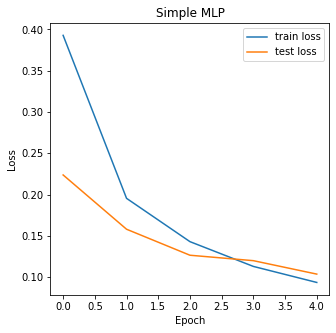

Metrics for model 0
Accuracy score: 0.9689
Precision score: 0.9688475799641918
Recall score score: 0.9684723922366592
F1 score: 0.9685768323784849
Training model 1


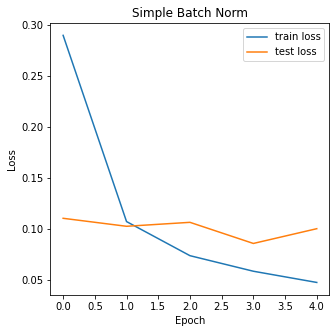

Metrics for model 1
Accuracy score: 0.9689
Precision score: 0.9688254961908574
Recall score score: 0.9687821004977856
F1 score: 0.9686416612527952
Training model 2


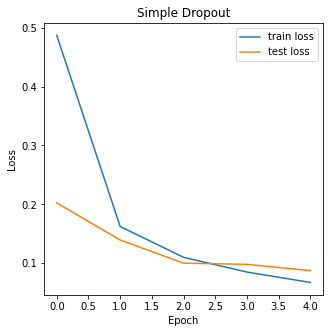

Metrics for model 2
Accuracy score: 0.973
Precision score: 0.9729687824870219
Recall score score: 0.9727021513492329
F1 score: 0.9727816015658497
Training model 3


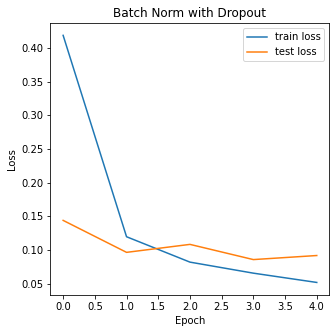

Metrics for model 3
Accuracy score: 0.9735
Precision score: 0.9737048795381549
Recall score score: 0.9730536536006642
F1 score: 0.9732488136908757


In [ ]:
tm2 = TrainModel2()
tm2.main()

### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!

In [13]:
# code here
class TrainModel3():
    def __init__(self):
        pass

    def train_model(self):
        self.train_loss, self.test_loss = list(), list()
        self.model.train()
        # pbar = tqdm(total=len(trainloader_stochastic))
        for epoch in range(5):
            tr_loss = 0
            for batch_idx, (data, target) in enumerate(trainloader_stochastic):
                data = data.view(-1, input_size)
                data = data.to(device)
                target = target.to(device)
                self.optimiser.zero_grad()
                out = self.model(data)
                loss = self.criterion(out, target)
                tr_loss += loss.item()

                loss.backward()
                self.optimiser.step()
                # pbar.update(1)
            x_l = tr_loss/len(trainloader_stochastic)
            self.train_loss.append(x_l)

            self.model.eval()
            with torch.no_grad():
                te_loss = 0
                for batch_idx, (data, target) in enumerate(testloader):
                    data = data.view(-1, input_size)
                    data = data.to(device)
                    target = target.to(device)
                    out = self.model(data)
                    loss = self.criterion(out, target)
                    te_loss += loss.item()
                x_l = te_loss/len(testloader)
                self.test_loss.append(x_l)
            # pbar.set_description(f"Epoch: {epoch}, Train Loss: {self.train_loss[-1]}, Test Loss: {self.test_loss[-1]}")
        # pbar.close()

    def plot_graph(self, choice):
        names = ['Mini Batch Model', 'Stochastic Model']
        name = names[choice]
        if choice == 1:
            self.train_loss = np.load('/content/drive/MyDrive/train_loss_model_5.npy')
            self.test_loss = np.load('/content/drive/MyDrive/test_loss_model_5.npy')
    
        fig, axs = plt.subplots(1,1,figsize=(5,5))
        axs.plot(self.train_loss, label='train loss')
        axs.plot(self.test_loss, label='test loss')
        axs.set_title(name)
        axs.set_xlabel('Epoch')
        axs.set_ylabel('Loss')
        axs.legend()
        plt.show()

    def get_metrics(self, choice):
        if choice == 1:
            self.model = SimpleMLP(input_size, hidden_size, output_size)
            self.model.load_state_dict(torch.load('/content/drive/MyDrive/MLP_model_5.pth'))
            self.model.to(device)
        y_pred, y_true = list(), list()
        for idx, (data, label) in enumerate(testloader):
            data = data.view(-1, input_size).to(device)
            label = label.to(device)
            out = self.model(data)
            y_pred.extend(out.argmax(dim=1).tolist())
            y_true.extend(label.tolist())

        print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
        print(f"Precision score: {precision_score(y_true, y_pred, average='macro')}")
        print(f"Recall score score: {recall_score(y_true, y_pred, average='macro')}")
        print(f"F1 score: {f1_score(y_true, y_pred, average='macro')}")

    def main(self):
        self.model = SimpleMLP(input_size, hidden_size, output_size).to(device)
        self.optimiser = Optimisers(self.model, lr=learning_rate).Adam(b1= 0.9, b2= 0.999, eps=1e-08)
        self.criterion = nn.CrossEntropyLoss()
        print(f"Training model")
        self.train_model()
        print('Plot for model 0')
        self.plot_graph(0)
        print(f"Metrics for model 0")
        self.get_metrics(0)

        print('Plot for model 1')
        self.plot_graph(1)
        print(f"Metrics for model 1")
        self.get_metrics(1)

Training model
Plot for model 0


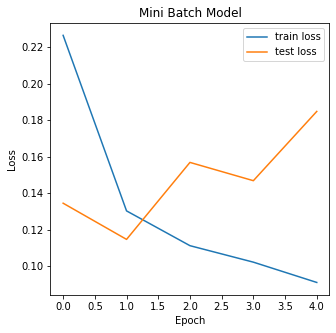

Metrics for model 0
Accuracy score: 0.9626
Precision score: 0.9623447442166736
Recall score score: 0.9626263689775685
F1 score: 0.9623049917295091
Plot for model 1


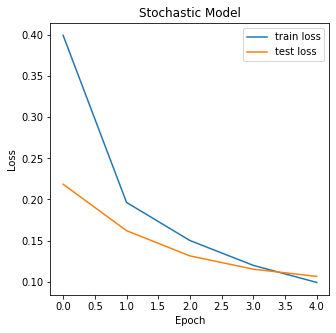

Metrics for model 1
Accuracy score: 0.9684
Precision score: 0.9684020201534688
Recall score score: 0.9680437280087322
F1 score: 0.9681440325645176


In [14]:
tm3 = TrainModel3()
tm3.main()

### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

In [ ]:
# text here